<a href="https://colab.research.google.com/github/shughes-21/TF2_Specialization/blob/main/Coding_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
print(tf.__version__)

2.9.2


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [1]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
# Save the input and target variables
#print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]


In [6]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0))/ targets.std()
targets


array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [7]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [9]:
# Build the model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense

def get_model():
  model = Sequential([
      Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(1)
    
  ])
  return model 
model = get_model()



In [10]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [41]:
# Train the model, with some of the data reserved for validation

epochs = 100
history = model.fit(train_data, train_targets, epochs=epochs, validation_split=0.15, batch_size=64, verbose=False)

In [42]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.6154 - mae: 0.6305 - 23ms/epoch - 12ms/step


[0.6154184937477112, 0.630483090877533]

#### Plot the learning curves

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

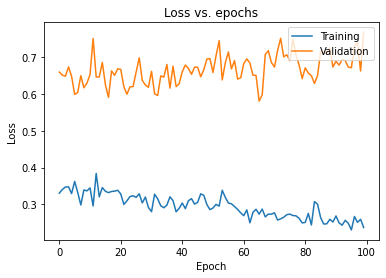

In [44]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [24]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [63]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [36]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3) # where 1e-5 is weight decay and 0.3 is dropout rate


In [37]:
# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [38]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [39]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.5185 - mae: 0.5711 - 21ms/epoch - 10ms/step


[0.518488883972168, 0.5711370706558228]

#### Plot the learning curves

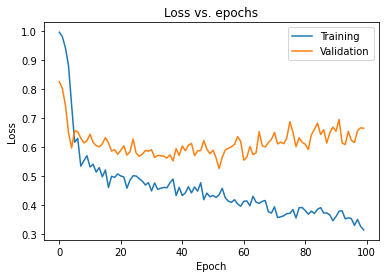

In [40]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [55]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class PredictionCallback(Callback):

  def on_predict_begin(self, logs=None):
    print("Starting prediction .....")

  def on_predict_batch_begin(self, batch, logs=None):
    print(f'Prediction: Starting batch {batch}')

  def on_predict_batch_end(self, batch, logs=None):
    print(f'Prediction: Finished batch {batch}')

  def on_predict_end(self, logs=None):
    print("Finished prediction! ")

    


In [48]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)


In [50]:
# Compile the model
model.compile(optimizer='adam', loss='mse')


#### Train the model with the callback

In [52]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])


Starting Training .....
starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training! 


In [54]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])


Starting testing .....
Testing: Starting batch 0
Test: Finished batch 0
Testing: Starting batch 1
Test: Finished batch 1
Finished testing! 


1.1971155405044556

In [56]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])


Starting prediction .....
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction! 


array([[ 0.1484653 ],
       [ 0.09582473],
       [-0.01548443],
       [ 0.1522116 ],
       [ 0.00493059],
       [ 0.11594612],
       [ 0.0213168 ],
       [ 0.08217763],
       [-0.00822229],
       [ 0.1006503 ],
       [-0.00781889],
       [-0.02139919],
       [ 0.04755202],
       [ 0.083042  ],
       [ 0.00099949],
       [ 0.11220956],
       [ 0.00187971],
       [-0.00814202],
       [ 0.09374152],
       [ 0.00419949],
       [ 0.14799652],
       [ 0.10463935],
       [ 0.1203846 ],
       [ 0.00974878],
       [-0.00758699],
       [ 0.10584714],
       [ 0.06590187],
       [-0.0121753 ],
       [ 0.11451609],
       [ 0.03523294],
       [ 0.10585314],
       [-0.00198831],
       [-0.0137476 ],
       [ 0.0969653 ],
       [-0.02164932],
       [ 0.08021361],
       [-0.00225994],
       [ 0.03134737],
       [ 0.15185934],
       [ 0.12347725],
       [ 0.1562252 ],
       [ 0.13558102],
       [ 0.08636354],
       [ 0.17039461],
       [ 0.11553729]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [72]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(train_data, train_targets, epochs=100, 
                                        validation_split=0.15,batch_size=64, verbose=False,
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
                                        )


In [65]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 1.0399 - 28ms/epoch - 14ms/step


1.0398634672164917

In [73]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
reg_history = regularised_model.fit(train_data, train_targets, epochs=100, 
                                    validation_split=0.15, batch_size=64, verbose=False,
                                    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)])

In [67]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 1.1806 - 21ms/epoch - 10ms/step


1.1805986166000366

#### Plot the learning curves

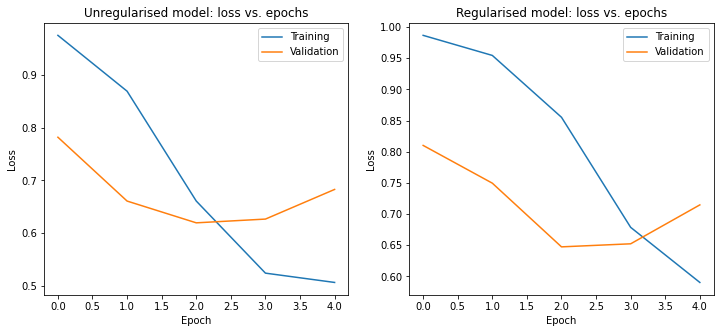

In [74]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()